In [2]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading the dataset
df = pd.read_csv('data/hospital_readmissions_30k.csv')
df.head()

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No


In [4]:
discharge_features = df['discharge_destination'].unique()
discharge_features

array(['Nursing_Facility', 'Home', 'Rehab'], dtype=object)

In [5]:
gender_features = df['gender'].unique()
gender_features

array(['Other', 'Female', 'Male'], dtype=object)

In [6]:
df.isnull().sum()

patient_id               0
age                      0
gender                   0
blood_pressure           0
cholesterol              0
bmi                      0
diabetes                 0
hypertension             0
medication_count         0
length_of_stay           0
discharge_destination    0
readmitted_30_days       0
dtype: int64

In [7]:
len(df)

30000

In [8]:
df.describe()

,patient_id,age,cholesterol,bmi,medication_count,length_of_stay
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,53.884233,225.260400,28.946263,5.012267,5.502900
std,8660.398374,21.056485,43.585671,6.348204,3.166383,2.867298
min,1.000000,18.000000,150.000000,18.000000,0.000000,1.000000
25%,7500.750000,36.000000,188.000000,23.400000,2.000000,3.000000
50%,15000.500000,54.000000,225.000000,28.900000,5.000000,5.000000
75%,22500.250000,72.000000,263.000000,34.500000,8.000000,8.000000
max,30000.000000,90.000000,300.000000,40.000000,10.000000,10.000000


In [9]:
df.head()

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No


#### Since `diabetes` and `hypertension` are either yes or no, we can use One Hot Encoding to convert them into numerical values, binari - Yes as 1 and No as 0m.

In [10]:
# Data preprocession
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X = df.drop('readmitted_30_days', axis=1)
y = df['readmitted_30_days']

# thhe patient_id column is irelevant, won't affcet classsification, we drop it
X = X.drop('patient_id', axis=1)

# Split the blood pressure into systols and distols
X[['systolic_bp', 'diastolic_bp']] = X['blood_pressure'].str.split('/', expand=True).astype(int)
X = X.drop('blood_pressure', axis=1)

X.head()


,age,gender,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,systolic_bp,diastolic_bp
0,74,Other,240,31.5,Yes,No,5,1,Nursing_Facility,130,72
1,46,Female,292,36.3,No,No,4,3,Nursing_Facility,120,92
2,89,Other,153,30.3,No,Yes,1,1,Home,135,78
3,84,Female,153,31.5,No,Yes,3,10,Home,123,80
4,32,Other,205,18.4,No,Yes,6,4,Nursing_Facility,135,84


In [11]:
# Encode target cariable, Yes to 1 and No to 0
le = LabelEncoder()
y = le.fit_transform(y)

y[:5]

array([1, 0, 0, 0, 0])

In [12]:
# Define numerical, categorical and nominal columns
X['gender'].unique(), X['diabetes'].unique(), X['hypertension'].unique(), X['discharge_destination'].unique() 

(array(['Other', 'Female', 'Male'], dtype=object),
 array(['Yes', 'No'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Nursing_Facility', 'Home', 'Rehab'], dtype=object))

In [13]:
numerical_cols = ['age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay', 'systolic_bp', 'diastolic_bp']
binary_cols = ['diabetes', 'hypertension']
nomial_cols = ['gender', 'discharge_destination']

# Create a pipeline to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('bin', OneHotEncoder(drop='if_binary', sparse_output=False), binary_cols),
        ('nom', OneHotEncoder(drop='first', sparse_output=False), nomial_cols)
    ]
)

# # the apply preprocessing
# for col in binary_cols:
#     X[col] = LabelEncoder().fit_transform(X[col])

# fit the preprocessor
preprocessor.fit(X)

# transform the data
X_transformed = preprocessor.transform(X)

# get features for Nominal columns after One Hot Encoding
bin_feature_names = preprocessor.named_transformers_['bin'].get_feature_names_out(binary_cols)
nom_feature_names = preprocessor.named_transformers_['nom'].get_feature_names_out(nomial_cols)

# combine all features names
features_names = numerical_cols + list(bin_feature_names) + list(nom_feature_names)

X_df = pd.DataFrame(X_transformed, columns=features_names)
X_df.head()

,age,cholesterol,bmi,medication_count,length_of_stay,systolic_bp,diastolic_bp,diabetes_Yes,hypertension_Yes,gender_Male,gender_Other,discharge_destination_Nursing_Facility,discharge_destination_Rehab
0,0.955340,0.338181,0.402284,-0.003874,-1.570459,-0.338645,-1.459778,1.0,0.0,0.0,1.0,1.0,0.0
1,-0.374439,1.531254,1.158416,-0.319697,-0.872927,-1.020252,0.781643,0.0,0.0,0.0,0.0,1.0,0.0
2,1.667721,-1.657921,0.213251,-1.267166,-1.570459,0.002158,-0.787351,0.0,1.0,0.0,1.0,0.0,0.0
3,1.430261,-1.657921,0.402284,-0.635520,1.568436,-0.815770,-0.563209,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.039328,-0.464849,-1.661326,0.311949,-0.524161,0.002158,-0.114925,0.0,1.0,0.0,1.0,1.0,0.0


In [14]:
X_df.columns, X.columns

(Index(['age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay',
        'systolic_bp', 'diastolic_bp', 'diabetes_Yes', 'hypertension_Yes',
        'gender_Male', 'gender_Other', 'discharge_destination_Nursing_Facility',
        'discharge_destination_Rehab'],
       dtype='object'),
 Index(['age', 'gender', 'cholesterol', 'bmi', 'diabetes', 'hypertension',
        'medication_count', 'length_of_stay', 'discharge_destination',
        'systolic_bp', 'diastolic_bp'],
       dtype='object'))

In [15]:
X.head()

,age,gender,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,systolic_bp,diastolic_bp
0,74,Other,240,31.5,Yes,No,5,1,Nursing_Facility,130,72
1,46,Female,292,36.3,No,No,4,3,Nursing_Facility,120,92
2,89,Other,153,30.3,No,Yes,1,1,Home,135,78
3,84,Female,153,31.5,No,Yes,3,10,Home,123,80
4,32,Other,205,18.4,No,Yes,6,4,Nursing_Facility,135,84


In [16]:
# training and testing the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2)

model = RandomForestClassifier(n_estimators=1001, class_weight='balanced')
model.fit(X_train, y_train)
model.score(X_train, y_train)


1.0

In [17]:
# make predictions and evaluate the model
y_preds = model.predict(X_test)

accuracy = accuracy_score(y_test, y_preds)
print("Accuracy: ", accuracy)

Accuracy:  0.8718333333333333


In [18]:
cfm = confusion_matrix(y_test, y_preds)
print(cfm)

[[5231    0]
 [ 769    0]]


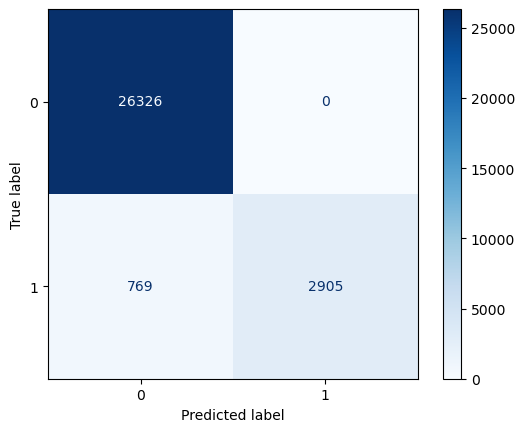

In [19]:

ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_df, y=y, cmap='Blues')



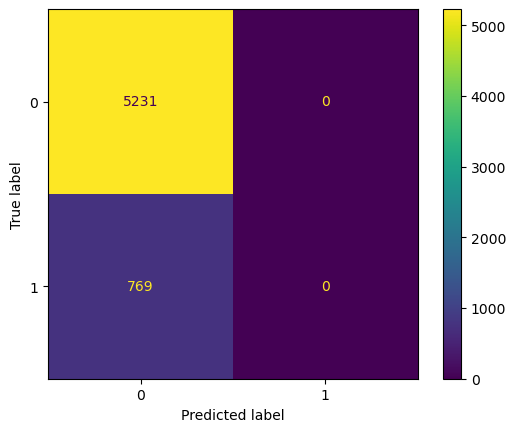

In [20]:

ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

In [21]:
import matplotlib.pyplot as plt

# Count of each class
class_counts = pd.Series(y).value_counts()
print("Class distribution:\n", class_counts)


Class distribution:
 0    26326
1     3674
Name: count, dtype: int64


In [22]:
class_proportions = class_counts / len(y)
print("Class proportions:\n", class_proportions)


Class proportions:
 0    0.877533
1    0.122467
Name: count, dtype: float64


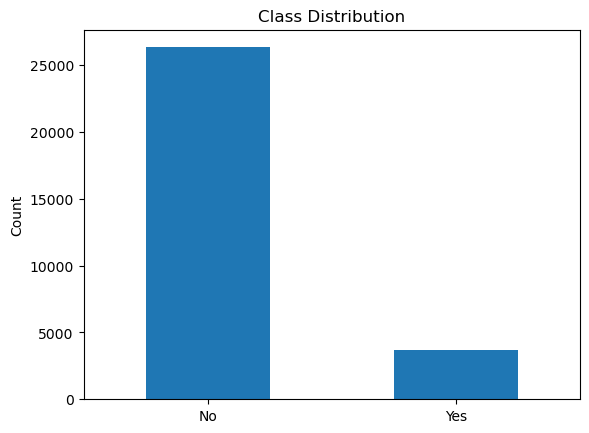

In [23]:
# Plot a bar chart
class_counts.plot(kind='bar', title='Class Distribution')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation=0)
plt.ylabel('Count')
plt.show()


In [24]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      5231
           1       0.00      0.00      0.00       769

    accuracy                           0.87      6000
   macro avg       0.44      0.50      0.47      6000
weighted avg       0.76      0.87      0.81      6000



c:\Users\Dee\Desktop\conda_projects\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dee\Desktop\conda_projects\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dee\Desktop\conda_projects\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [25]:
import sys
!conda install --yes --prefix {sys.prefix} imbalanced-learn

Channels:
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.



In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_df, y)

# Train-test split after resampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [27]:
# train and test 
estimator = RandomForestClassifier(n_estimators=1001, class_weight='balanced')
estimator.fit(X_train, y_train)

estimator.score(X_test, y_test)

0.9335295793371949

In [28]:
# evaluation
y_preds = estimator.predict(X_test)

print(confusion_matrix(y_test, y_preds))

[[5123   59]
 [ 641 4708]]


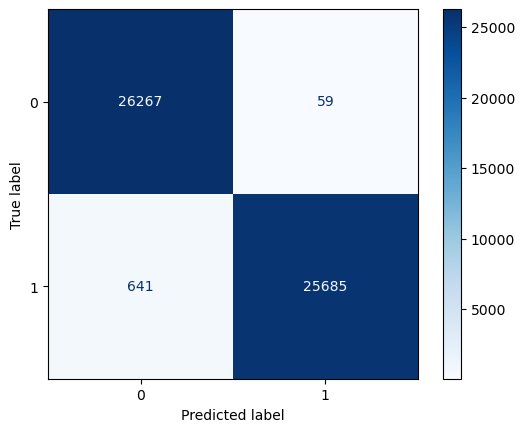

In [29]:
ConfusionMatrixDisplay.from_estimator(estimator=estimator, X=X_resampled, y=y_resampled, cmap='Blues')

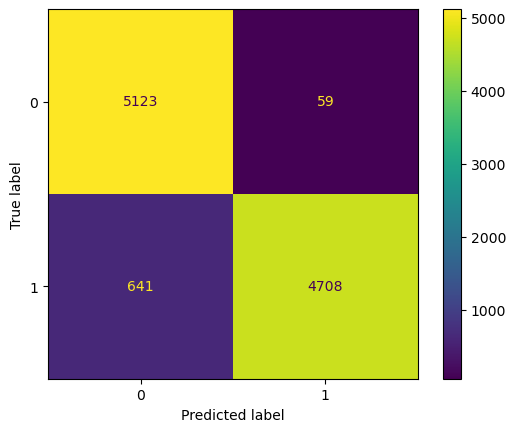

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

In [31]:
print(classification_report(y_test, y_preds, target_names=['No Readmission', 'Readmitted']))

                precision    recall  f1-score   support

No Readmission       0.89      0.99      0.94      5182
    Readmitted       0.99      0.88      0.93      5349

      accuracy                           0.93     10531
     macro avg       0.94      0.93      0.93     10531
  weighted avg       0.94      0.93      0.93     10531



In [32]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(estimator, X_resampled, y_resampled, cv=5)

print(f'Cross Validation Score: {cv_score}')

Cross Validation Score: [0.72386288 0.98661096 0.98774929 0.98774929 0.98537512]


In [33]:
print(f"Accuracy score: {cv_score.mean()}")

Accuracy score: 0.934269506669722


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8, 10, 20, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(10),
    n_jobs=-1,
    verbose=1,
    scoring='f1'
)

grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
